In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import KFold

import cv2
import random
from PIL import Image
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

/mnt/local/yuxin/anaconda3/envs/gender/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2022-11-10 18:16:04.476265: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


2.4.1


In [2]:
# ViT
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# import tensorflow_addons as tfa

## Preprocess Adience Dataset

In [3]:
#load data
ADIENCE_PATH = './Adience'
# print(os.listdir(path=ADIENCE_PATH))
all_folds={}
for i in range(5):
    all_folds[i]=pd.read_csv(os.path.join(ADIENCE_PATH, f'fold_{i}_data.txt'),sep = "\t" )

In [4]:
total_data = pd.concat([all_folds[i] for i in range(5)],ignore_index=True)
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             19370 non-null  object
 1   original_image      19370 non-null  object
 2   face_id             19370 non-null  int64 
 3   age                 19370 non-null  object
 4   gender              18591 non-null  object
 5   x                   19370 non-null  int64 
 6   y                   19370 non-null  int64 
 7   dx                  19370 non-null  int64 
 8   dy                  19370 non-null  int64 
 9   tilt_ang            19370 non-null  int64 
 10  fiducial_yaw_angle  19370 non-null  int64 
 11  fiducial_score      19370 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.8+ MB


In [5]:
total_data.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


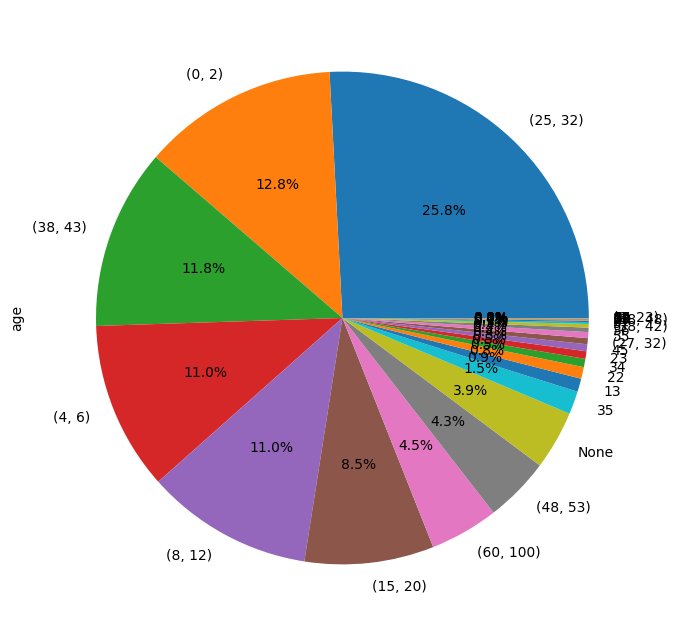

In [6]:
#pie_graph
plt.figure(1, figsize=(8,8))
total_data.age.value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

f    9372
m    8120
u    1099
Name: gender, dtype: int64


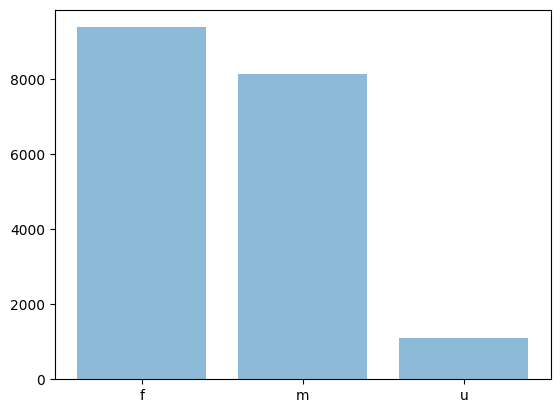

In [7]:
#bar chart
gender = ['f','m','u']
plt.bar(gender, total_data.gender.value_counts(), align='center', alpha=0.5)
print(total_data.gender.value_counts())
plt.show()

In [8]:
df = total_data[['age', 'gender', 'x', 'y', 'dx', 'dy']].copy()

img_path = []

for row in total_data.iterrows():
    path = f"{ADIENCE_PATH}/faces/"+row[1].user_id+"/coarse_tilt_aligned_face."+str(row[1].face_id)+"."+row[1].original_image
    img_path.append(path)
df['img_path'] = img_path

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       19370 non-null  object
 1   gender    18591 non-null  object
 2   x         19370 non-null  int64 
 3   y         19370 non-null  int64 
 4   dx        19370 non-null  int64 
 5   dy        19370 non-null  int64 
 6   img_path  19370 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.0+ MB


In [9]:
age_mapping = [('(0, 2)', '0-2'), ('2', '0-2'), ('3', '0-2'), ('(4, 6)', '4-6'), ('(8, 12)', '8-13'), ('13', '8-13'), ('22', '15-20'), ('(8, 23)','15-20'), ('23', '25-32'), ('(15, 20)', '15-20'), ('(25, 32)', '25-32'), ('(27, 32)', '25-32'), ('32', '25-32'), ('34', '25-32'), ('29', '25-32'), ('(38, 42)', '38-43'), ('35', '38-43'), ('36', '38-43'), ('42', '48-53'), ('45', '38-43'), ('(38, 43)', '38-43'), ('(38, 42)', '38-43'), ('(38, 48)', '48-53'), ('46', '48-53'), ('(48, 53)', '48-53'), ('55', '48-53'), ('56', '48-53'), ('(60, 100)', '60+'), ('57', '60+'), ('58', '60+')]

age_mapping_dict = {each[0]: each[1] for each in age_mapping}
drop_labels = []
for idx, each in enumerate(df.age):
    if each == 'None':
        drop_labels.append(idx)
    else:
        df.age.loc[idx] = age_mapping_dict[each]

df = df.drop(labels=drop_labels, axis=0) #droped None values
df.age.value_counts(dropna=False)


/tmp/ipykernel_27764/3196150795.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = age_mapping_dict[each]


25-32    5296
38-43    2776
0-2      2509
8-13     2292
4-6      2140
15-20    1792
48-53     916
60+       901
Name: age, dtype: int64

In [10]:
df = df.dropna()
unbiased_data = df[df.gender != 'u'].copy()
unbiased_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17452 entries, 0 to 19345
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       17452 non-null  object
 1   gender    17452 non-null  object
 2   x         17452 non-null  int64 
 3   y         17452 non-null  int64 
 4   dx        17452 non-null  int64 
 5   dy        17452 non-null  int64 
 6   img_path  17452 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.1+ MB


In [11]:
gender_to_label_map = {
    'f' : 0,
    'm' : 1
}

age_to_label_map = {
    '0-2'  :0,
    '4-6'  :1,
    '8-13' :2,
    '15-20':3,
    '25-32':4,
    '38-43':5,
    '48-53':6,
    '60+'  :7
}

# label_to_age_map = {value: key for key, value in age_to_label_map.items()}
# label_to_gender_map = {value: key for key, value in gender_to_label_map.items()}

unbiased_data['age'] = unbiased_data['age'].apply(lambda age: age_to_label_map[age])
unbiased_data['gender'] = unbiased_data['gender'].apply(lambda g: gender_to_label_map[g])

unbiased_data.head()

,age,gender,x,y,dx,dy,img_path
0,4,0,0,414,1086,1383,./Adience/faces/30601258@N03/coarse_tilt_align...
1,4,1,301,105,640,641,./Adience/faces/30601258@N03/coarse_tilt_align...
2,4,0,2395,876,771,771,./Adience/faces/30601258@N03/coarse_tilt_align...
3,4,1,752,1255,484,485,./Adience/faces/30601258@N03/coarse_tilt_align...
4,4,1,175,80,769,768,./Adience/faces/30601258@N03/coarse_tilt_align...


### create dataset

In [12]:
X = unbiased_data[['img_path']]
y = unbiased_data[['gender']]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Train data shape {}'.format(X_train.shape))
print('Test data shape {}'.format(X_test.shape))

Train data shape (12216, 1)
Test data shape (5236, 1)


In [13]:
train_images = []
test_images = []

for row in X_train.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))   # Resize the image
    data = np.asarray(image)
    train_images.append(data)

for row in X_test.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))  # Resize the image
    data = np.asarray(image)
    test_images.append(data)

train_images = np.asarray(train_images)
test_images = np.asarray(test_images)

print('Train images shape {}'.format(train_images.shape))
print('Test images shape {}'.format(test_images.shape))

Train images shape (12216, 227, 227, 3)
Test images shape (5236, 227, 227, 3)


## Create Model

In [14]:
batch_size=1
epochs=20
target_size = (227,227) # (64, 64)
input_shape= (227,227,3) #(64, 64, 3)

# random seed
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

adam = 0.001
fre= -20
FC = 2048
E = 1
patience = 3
verbose = 1
factor = 0.50
min_lr = 0.0001
steps_per_epoch=256
validation_steps=256
num_classes = 2

## ViT specific params
patch_size = 6 
image_size = input_shape[0]
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024] 

In [15]:
def get_call_backs(name):
    lrd = ReduceLROnPlateau(monitor = 'val_loss',
                            patience = patience,
                            verbose = verbose ,
                            factor = factor,
                            min_lr = min_lr)

    # if not os.path.exists(f'ckpt/{name}'):
    #    os.makedirs('ckpt/{name}')
    # mcp = ModelCheckpoint('vit_model.h5')

    es = EarlyStopping(verbose=verbose, patience=patience)
    return [lrd, es]

### Vision Transformer (ViT)

In [16]:
# Implement multilayer perceptron (MLP)
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [17]:
# Implement patch creation as a layer

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [18]:
# Implement the patch encoding layer
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [19]:
# Build the ViT model

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
#     augmented = data_augmentation(inputs)
    augmented = inputs

    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(1, activation='sigmoid')(features)
    print(num_classes)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [20]:
vit_classifier = create_vit_classifier()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-11-10 18:17:05.816306: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-10 18:17:05.816937: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-10 18:17:05.859904: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 18:17:05.860248: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-11-10 18:17:05.860290: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node ze

2


In [21]:
# training
model_wo = vit_classifier
model_wo.compile(optimizer=Adam(adam),
              loss='binary_crossentropy'
              ,metrics=['accuracy'])
## can try two entropies
# model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
# history = model.fit(train_images, y_train, batch_size=32, epochs=5, validation_data=(test_images, y_test), callbacks=[callback])

In [22]:
model_wo.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
patches (Patches)               (None, None, 108)    0           input_1[0][0]                    
__________________________________________________________________________________________________
patch_encoder (PatchEncoder)    (None, 1369, 64)     94592       patches[0][0]                    
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 1369, 64)     128         patch_encoder[0][0]              
______________________________________________________________________________________________

In [23]:
# train_images
# history = model.fit(
#         x=x_train,
#         y=y_train,
#         batch_size=batch_size,
#         epochs=num_epochs,
#         validation_split=0.1,
#         callbacks=get_call_backs('ViT_wo'),
#     )

history_wo = model_wo.fit(train_images, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(test_images, y_test), 
                    callbacks=get_call_backs('ViT_wo'))

2022-11-10 18:17:06.944846: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1888434792 exceeds 10% of free system memory.
2022-11-10 18:17:07.485741: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-10 18:17:07.504951: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3099995000 Hz


Epoch 1/20


2022-11-10 18:17:10.369918: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


12216/12216 [==============================] - 641s 52ms/step - loss: 22.8849 - accuracy: 0.5114 - val_loss: 0.6900 - val_accuracy: 0.5378
Epoch 2/20
12216/12216 [==============================] - 646s 53ms/step - loss: 0.8883 - accuracy: 0.5186 - val_loss: 0.6933 - val_accuracy: 0.5239
Epoch 3/20
12216/12216 [==============================] - 648s 53ms/step - loss: 0.7829 - accuracy: 0.5195 - val_loss: 0.6922 - val_accuracy: 0.5241
Epoch 4/20
12216/12216 [==============================] - 651s 53ms/step - loss: 0.7662 - accuracy: 0.5195 - val_loss: 0.6929 - val_accuracy: 0.5241

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 00004: early stopping


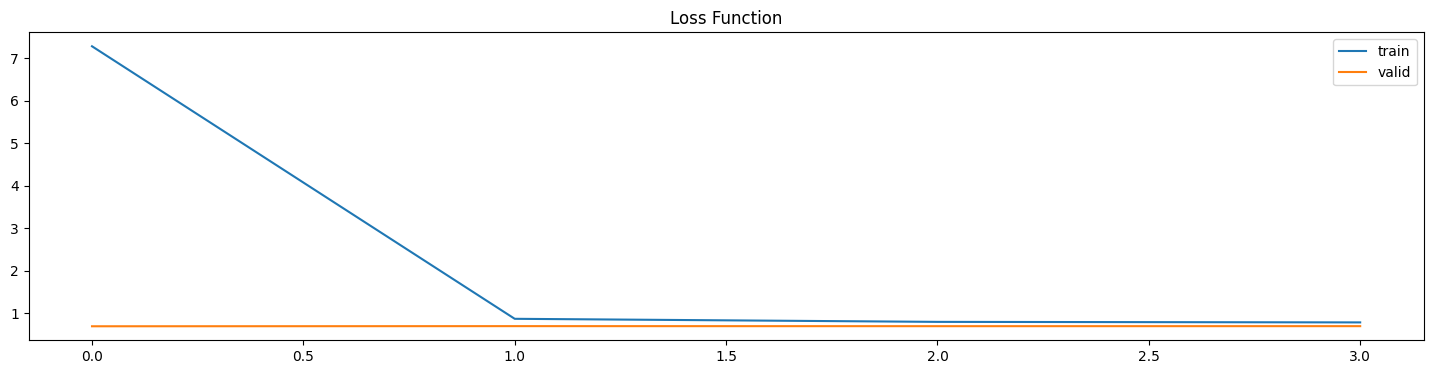

In [26]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(history_wo.history['loss'], label = 'train')
plt.plot(history_wo.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

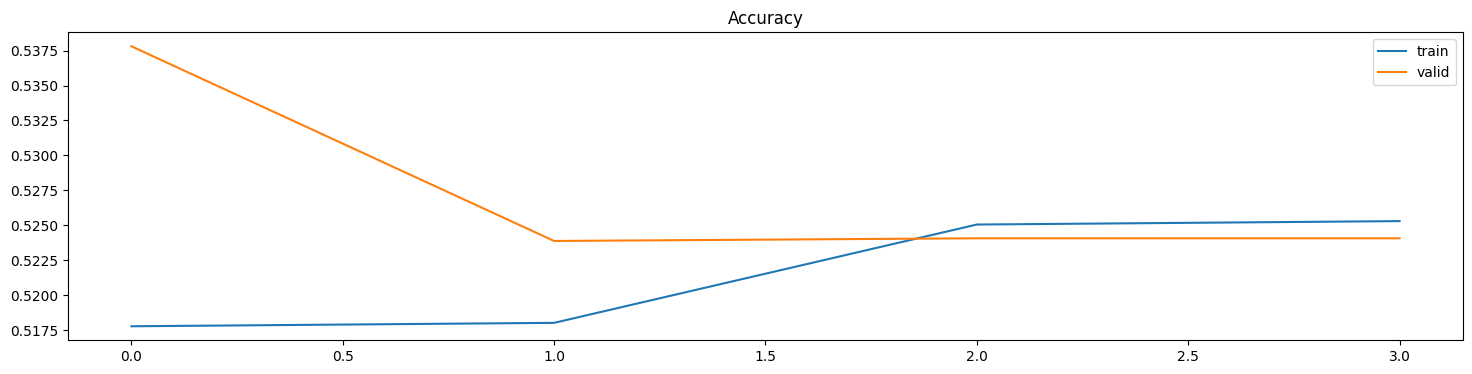

In [27]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(history_wo.history['accuracy'], label = 'train')
plt.plot(history_wo.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [28]:
# test
test_loss, test_acc = model_wo.evaluate(test_images, y_test, verbose=2)
print(test_acc)

164/164 - 35s - loss: 0.6929 - accuracy: 0.5241
0.5240641832351685


In [30]:
from tensorflow.keras.utils import plot_model
model_wo.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
patches (Patches)               (None, None, 108)    0           input_1[0][0]                    
__________________________________________________________________________________________________
patch_encoder (PatchEncoder)    (None, 1369, 64)     94592       patches[0][0]                    
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 1369, 64)     128         patch_encoder[0][0]              
______________________________________________________________________________________________